### import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Add
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import sklearn
from sklearn.model_selection import train_test_split

### data 경로
`computer-vision/contests/plant_pathology/data` 폴더 안에 캐글 데이터 다운로드

In [2]:
!pwd

/workspace/computer-vision/contests/plant_pathology


### dataframe 구축

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
train_df["path"] = "./data/images/" + train_df["image_id"] + ".jpg"
test_df["path"] = "./data/images/" + test_df["image_id"] + ".jpg"

In [5]:
def get_label(x):
    labels = ["healthy", "multiple_diseases", "rust", "scab"]
    for label in labels:
        if x[label]:
            return label

In [6]:
train_df["label"] = train_df.apply(get_label, axis=1)

In [7]:
train_df["label"].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [8]:
train_df

,image_id,healthy,multiple_diseases,rust,scab,path,label
0,Train_0,0,0,0,1,./data/images/Train_0.jpg,scab
1,Train_1,0,1,0,0,./data/images/Train_1.jpg,multiple_diseases
2,Train_2,1,0,0,0,./data/images/Train_2.jpg,healthy
3,Train_3,0,0,1,0,./data/images/Train_3.jpg,rust
4,Train_4,1,0,0,0,./data/images/Train_4.jpg,healthy
...,...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,./data/images/Train_1816.jpg,scab
1817,Train_1817,1,0,0,0,./data/images/Train_1817.jpg,healthy
1818,Train_1818,1,0,0,0,./data/images/Train_1818.jpg,healthy
1819,Train_1819,0,0,1,0,./data/images/Train_1819.jpg,rust


### 이미지 데이터 시각화

In [9]:
def show_images(img_path_list, ncols=6, title=None, augmentor=None):
    fig, axs = plt.subplots(figsize=(20, 20), nrows=1, ncols=ncols)
    
    for i in range(ncols):
        img = cv2.cvtColor(cv2.imread(img_path_list[i+23]), cv2.COLOR_BGR2RGB)
        if augmentor:
            img = augmentor(image=img)['image']
        axs[i].imshow(img)
        axs[i].set_title(title)

In [10]:
rust_img_list = list(train_df[train_df["rust"] == 1]["path"])
scab_img_list = list(train_df[train_df["scab"] == 1]["path"])
healthy_img_list = list(train_df[train_df["healthy"] == 1]["path"])
multiple_diseases_img_list = list(train_df[train_df["multiple_diseases"] == 1]["path"])

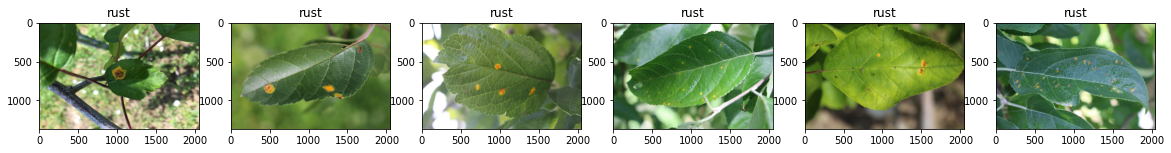

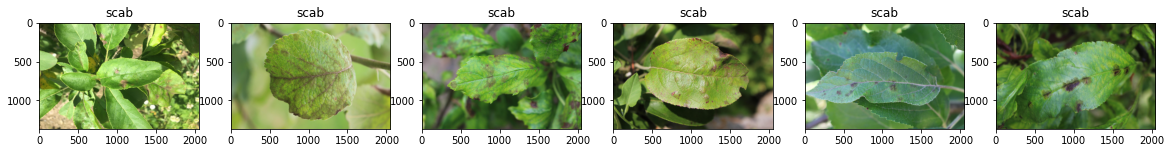

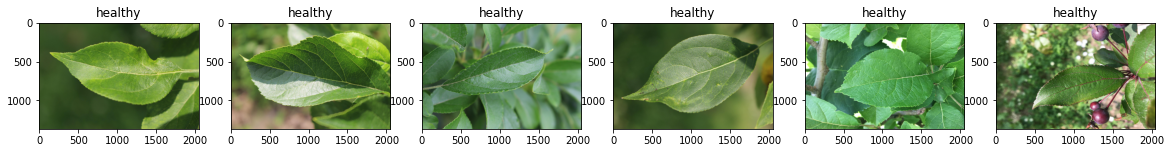

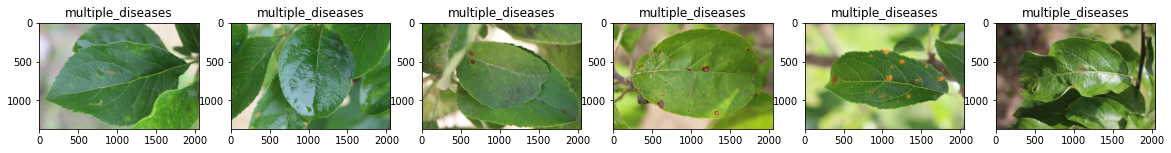

In [11]:
show_images(rust_img_list, title="rust")
show_images(scab_img_list, title="scab")
show_images(healthy_img_list, title="healthy")
show_images(multiple_diseases_img_list, title="multiple_diseases")

### augmentation

In [12]:
aug_01 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, always_apply=True),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.CenterCrop(height=1365, width=1365, p=1.0)
])

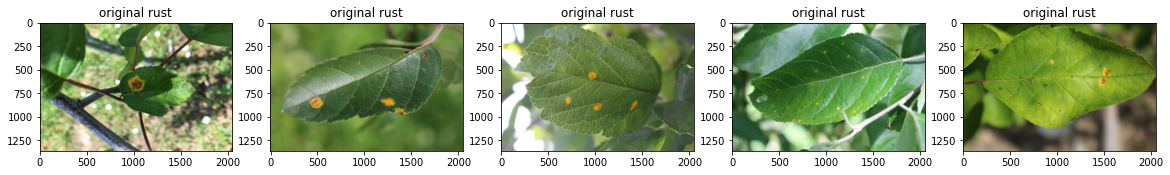

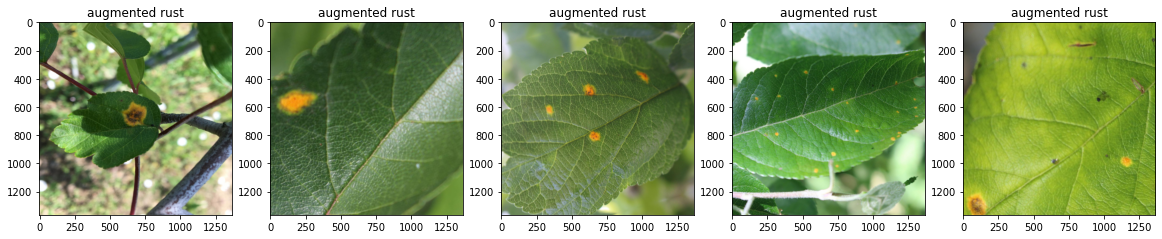

In [13]:
show_images(rust_img_list, ncols=5, title='original rust', augmentor=None)
show_images(rust_img_list, ncols=5, title='augmented rust', augmentor=aug_01)

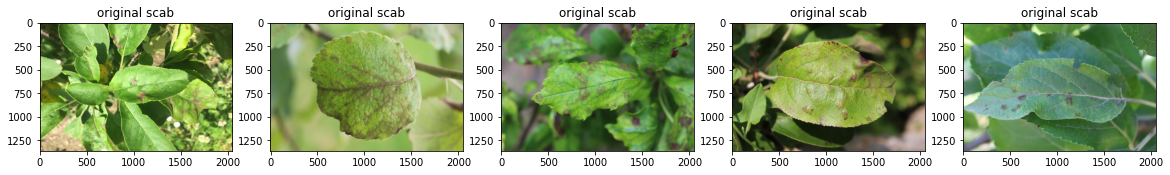

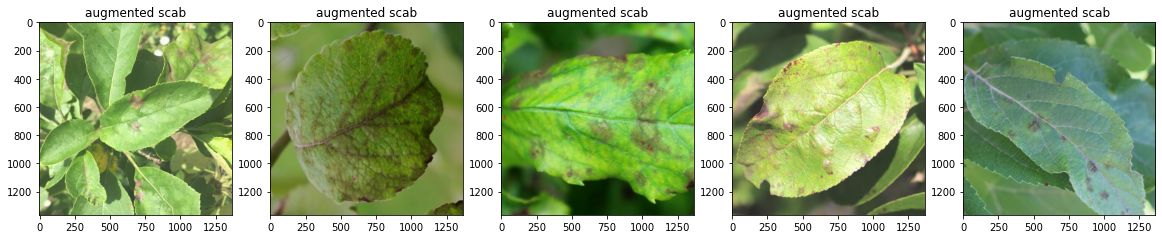

In [14]:
show_images(scab_img_list, ncols=5, title='original scab', augmentor=None)
show_images(scab_img_list, ncols=5, title='augmented scab', augmentor=aug_01)

### `tensorflow.keras.utils.Sequence` 기반의 dataset 구축

In [15]:
class Plant_Sequence(Sequence):
    
    def __init__(self, path_list, y_list, height, width, batch_size=64, augmentor=None, preprocess=None, shuffle=True):
        self.path_list = path_list
        self.y_list = y_list
        self.height = height
        self.width = width
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.preprocess = preprocess
        self.shuffle = shuffle
        if self.shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.path_list) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_path = self.path_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x_list = []
        batch_y = None if self.y_list is None else self.y_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        for path in batch_path:
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            if self.augmentor:
                img = self.augmentor(image=img)['image']
            img = cv2.resize(img, (self.width, self.height))
            if self.preprocess:
                img = self.preprocess(img)
            
            batch_x_list.append(img)
        
        batch_x = np.array(batch_x_list)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.path_list))
            np.random.shuffle(idxs)
            self.path_list = self.path_list[idxs]
            self.y_list = self.y_list[idxs]
            #self.path_list, self.y_list = sklearn.utils.shuffle(self.path_list, self.y_list)

### preprocess 함수

In [16]:
def pre_m1_to_p1(data):
    return data / 127.5 - 1

In [17]:
def pre_zero_to_one(data):
    return data / 255

In [21]:
def pre_mean_zero(data):
    data.astype('float32')
    mean = np.array([123.68, 116.779, 103.939], dtype='float32')
    data[0] -= mean[0]
    data[1] -= mean[1]
    data[2] -= mean[2]
    
    return data

### train dataset과 validation dataset으로 분리

In [19]:
def train_valid_split(train_df, valid_size=0.2, random_state=2023):
    path = train_df["path"].values
    y = train_df[["healthy", "multiple_diseases", "rust", "scab"]].values
    
    # path_train, path_valid, y_train, y_valid
    return train_test_split(path, y, test_size=valid_size, random_state=random_state)

In [22]:
HEIGHT, WIDTH = 224, 224
BATCH_SIZE = 32

path_train, path_valid, y_train, y_valid = train_valid_split(train_df, valid_size=0.2, random_state=2023)

train_dataset = Plant_Sequence(
    path_list=path_train, y_list=y_train,
    height=HEIGHT, width=WIDTH,
    batch_size=BATCH_SIZE,
    augmentor=aug_01,
    preprocess=pre_mean_zero,
    shuffle=False
)

valid_dataset = Plant_Sequence(
    path_list=path_valid, y_list=y_valid,
    height=HEIGHT, width=WIDTH,
    batch_size=BATCH_SIZE,
    augmentor=aug_01,
    preprocess=pre_mean_zero,
    shuffle=False
)

batch_x_train, batch_y_train = next(iter(train_dataset))
batch_x_valid, batch_y_valid = next(iter(valid_dataset))
print(batch_x_train.shape, batch_x_valid.shape, batch_y_train.shape, batch_y_valid.shape)
print(batch_x_train[0], batch_x_valid[0])

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float32') to dtype('uint8') with casting rule 'same_kind'

In [ ]:
batch_x_train.shape

In [ ]:
batch_y_train.shape

In [ ]:
batch_x_valid.shape

In [ ]:
batch_y_valid.shape

### resnet model

In [ ]:
def identity_block(input_tensor, middle_kernel_size, filters, stage, block):
    filter1, filter2, filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(filters=filter1, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base+'2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base+'2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2c')(x)
    
    x = Add()([input_tensor, x])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def conv_block(input_tensor, middle_kernel_size, filters, stage, block, strides=(2, 2)):
    filter1, filter2, filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(filters=filter1, kernel_size=(1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base+'2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base+'2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filter2, kernel_size=middle_kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base+'2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal', name=conv_name_base+'2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base+'2c')(x)
    
    shortcut = Conv2D(filter3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base+'1')(input_tensor)
    shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def do_first_conv(input_tensor):
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(input_tensor)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
 
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    return x

In [ ]:
def create_resnet(in_shape=(224, 224, 3), n_classes=10):
    input_tensor = Input(shape=in_shape)
      
    x = do_first_conv(input_tensor)
    
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
 
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    #x = Dropout(rate=0.5)(x)
    x = Dense(1024, activation='relu', name='fc_01')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(n_classes, activation='softmax', name='fc_final')(x)
    
    model = Model(inputs=input_tensor, outputs=output, name='resnet50')
    #model.summary()
    
    return model

In [ ]:
resnet_model = create_resnet(in_shape=(224,224,3), n_classes=4)
resnet_model.summary()

In [ ]:
from tensorflow.keras.metrics import AUC, Accuracy

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[AUC(), Accuracy()])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
history = resnet_model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=([rlr_cb, ely_cb]), verbose=1)